In [1]:
#%matplotlib inline
import ROOT
ROOT.gSystem.Load("/mnt/c/Users/marratia/Linux/RooUnfold/libRooUnfold")
from ROOT import gRandom, TH1, TH1D, cout
#for unfolding
from ROOT import RooUnfoldResponse
from ROOT import RooUnfold
from ROOT import RooUnfoldBayes
from ROOT import RooUnfoldSvd
from ROOT import RooUnfoldTUnfold
from ROOT import RooUnfoldBinByBin
from ROOT import RooUnfoldIds

#plotting, style
from matplotlib import pyplot as plt
ROOT.gStyle.SetOptStat('')
from AtlasCommonUtils import SetAtlasStyle
from Legend import Legend
from ROOT import TLatex
SetAtlasStyle()
ROOT.gStyle.SetPalette(ROOT.kViridis);


Welcome to JupyROOT 6.09/01


/root/myROOT/lib/ROOT.py:432: UserWarning: "from ROOT import *" is not supported under IPython
  warnings.warn( '"from ROOT import *" is not supported under IPython' )


### Get Data and MC files

In [13]:
Datafile = ROOT.TFile('/mnt/c/Users/marratia/Linux/PionHadronCorr/NtupleAnalysis/GammaJet_config_17q_CENT_wSDD_clusv1_small.root')
#MCfile   = ROOT.TFile('/mnt/c/Users/marratia/Linux/PionHadronCorr/NtupleAnalysis/GammaJet_config_16c3c_pthat2_v1.root')
MCfile    = ROOT.TFile('/mnt/c/Users/marratia/Linux/PionHadronCorr/NtupleAnalysis/GammaJet_config_18b10ab_calo_pthat1to4.root')

hSR_Xj =  Datafile.Get('hSR_Xj')
hBR_Xj =  Datafile.Get('hBR_Xj')
hSR_dPhi = Datafile.Get('hSR_dPhi')
hBR_dPhi = Datafile.Get('hBR_dPhi')

hSR_Xj_truth = MCfile.Get('hSR_Xj_truth')

nrebin = 1
hSR_Xj.Rebin(nrebin)
hBR_Xj.Rebin(nrebin)
hSR_dPhi.Rebin(nrebin)
hBR_dPhi.Rebin(nrebin)
hSR_Xj_truth.Rebin(nrebin)

purity = 0.25
hBR_dPhi.Scale(1.0-purity)
hBR_Xj.Scale(1.0-purity)


### Get response Matrix and plot it, also true/reco ratio

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file UnfoldingMatrix.png has been created


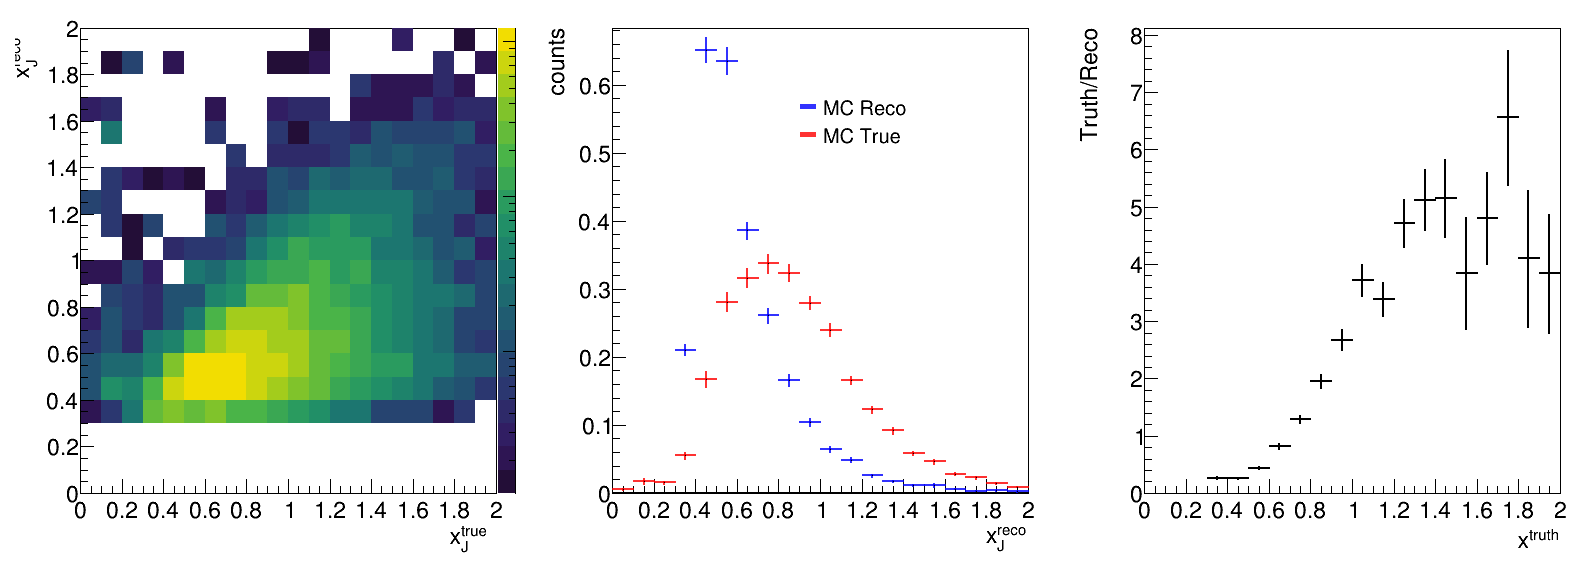

In [42]:
responseMatrix = MCfile.Get("xj_matrix");
responseMatrix.Rebin2D(nrebin,nrebin)#
#responseMatrix.ClearUnderflowAndOverflow()
mc_truth = responseMatrix.ProjectionX()
mc_reco = responseMatrix.ProjectionY()
#mc_truth.Sumw2()
#mc_reco.Sumw2()
mc_truth.SetLineColorAlpha(2,0.8)
mc_reco.SetLineColorAlpha(4,0.8)

##draw mc truth, mc reco, response matrix
c = ROOT.TCanvas('c','c',1600,600)
c.Divide(3)
c.cd(1)
responseMatrix.Draw('colz')
responseMatrix.SetTitle('; x^{true}_{J} ; x^{reco}_{J} ')

ROOT.gPad.SetLogz()
c.cd(2)

label = Legend("")
label.Add(mc_reco,'MC Reco','L')
label.Add(mc_truth,'MC True','L')

hs_mc = ROOT.THStack()
hs_mc.Add(mc_reco)
hs_mc.Add(mc_truth)
hs_mc.Draw('nostack')
hs_mc.SetTitle(';  x^{reco}_{J}; counts')

label.Draw(0.5,.87)
#ROOT.gPad.SetLogy()
c.cd(3)
ratio_mc = mc_truth.Clone()
ratio_mc.SetMinimum(0)
ratio_mc.SetLineColor(1)
ratio_mc.Divide(mc_reco)
ratio_mc.Draw()
ratio_mc.SetTitle(' ; x^{truth}; Truth/Reco')
c.Draw()
c.SaveAs('UnfoldingMatrix.png')

### Get measured track pt spectrum

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


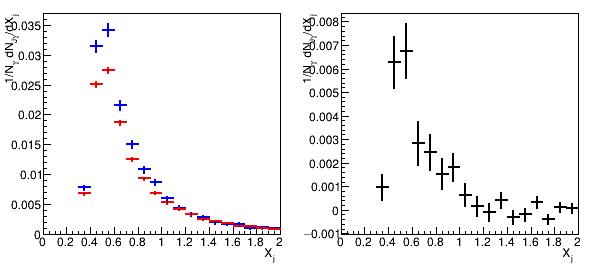

In [18]:
#Get histigrams and subtract background
hSR_Xj.SetLineColor(4)
hBR_Xj.SetLineColor(2)
hSR_dPhi.SetLineColor(4)
hBR_dPhi.SetLineColor(2)

hSub_Xj = hSR_Xj.Clone()
hSub_dPhi = hSR_dPhi.Clone()

hSub_Xj.Add(hBR_Xj,-1.0)
hSub_dPhi.Add(hBR_dPhi,-1.0)

c = ROOT.TCanvas('c','c',600,300)
c.Divide(2)
c.cd(1)
hSR_Xj.Draw()
hBR_Xj.Draw('same')
c.cd(2)
hSub_Xj.SetLineColor(1)
hSub_Xj.Draw()
c.Draw()



### Get and plot efficiency and fake rate

### DEFINE DATA FOR UNFOLDING 

In [19]:
data_inputforunfolding = hSub_Xj
data                   = hSub_Xj.Clone()
#data_bkgsub.Clone()
#data_inputforunfolding = data.Clone()

### UNFOLDING 

In [54]:
response= RooUnfoldResponse(mc_reco, mc_truth, responseMatrix)
#response.UseOverflow(ROOT.kFALSE)
data_unfolded = {}
#for tau in range(4,6):
#    data_unfolded['SVD%i'%tau] = RooUnfoldSvd(response, data_inputforunfolding, tau).Hreco();
   
nbayes_iter = 1
data_unfolded['Bayes'] = RooUnfoldBayes(response, data_inputforunfolding, nbayes_iter).Hreco();

SVD_k = 2
data_unfolded['SVD'] = RooUnfoldSvd(response, data_inputforunfolding, SVD_k).Hreco();
data_unfolded['SVD_next'] = RooUnfoldSvd(response, data_inputforunfolding, SVD_k+1).Hreco();


data_unfolded['binbybin'] = RooUnfoldBinByBin(response, data_inputforunfolding).Hreco();

data_unfolded['IDS']  = RooUnfoldIds(response, data_inputforunfolding, 5).Hreco();

#print data_unfolded

Add truth bin for 0.00908047 fakes
Now unfolding...
Iteration : 0
Chi^2 of change 1.4248e-05
Calculating covariances due to number of measured events
Subtract 8.10998e-05 fakes from measured distribution
SVD init 20 x 20 bins, kreg=2
Subtract 8.10998e-05 fakes from measured distribution
SVD init 20 x 20 bins, kreg=3
Subtract 8.10998e-05 fakes from measured distribution
Add truth bin for 0.00908047 fakes
IDS init 21 x 21


Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 2
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000000
Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 3
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.000004


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file Unfoldedresult.png has been created


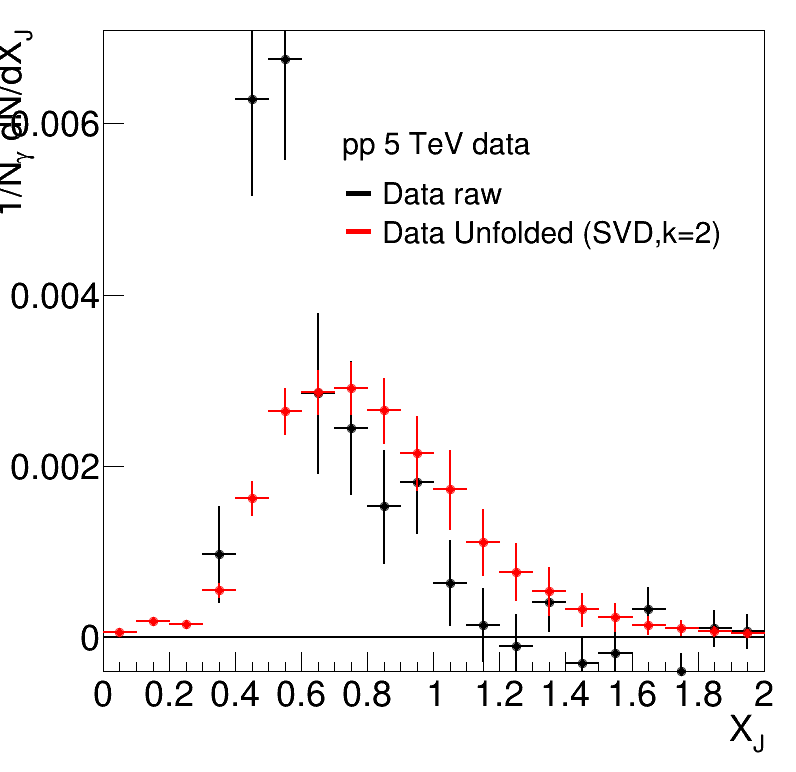

In [55]:
c = ROOT.TCanvas('c','c',800,800)

label = Legend("pp 5 TeV data")

hstack = ROOT.THStack()
hstack.Add(data)
label.Add(data,'Data raw','L')

data.SetMarkerStyle(20)
data_unfolded['SVD'].SetLineColor(2)
data_unfolded['SVD'].SetMarkerColor(2)
data_unfolded['SVD'].SetMarkerStyle(20)
data_unfolded['SVD_next'].SetMarkerColorAlpha(4,0)

data_unfolded['Bayes'].SetLineColor(4)
data_unfolded['binbybin'].SetLineColor(8)

data_unfolded['IDS'].SetLineColor(50) 

#hstack.Add(data_unfolded['Bayes'])
#hstack.Add(data_unfolded['binbybin']) 
#hstack.Add(data_unfolded['IDS'] )
hstack.Add(data_unfolded['SVD'])
#hstack.Add(data_unfolded['SVD_next'])


#label.Add(data_unfolded['Bayes'],'Bayes (%i iter)'%nbayes_iter,'L')      
#label.Add(data_unfolded['binbybin'],'Bin-by-bin','L')
label.Add(data_unfolded['SVD'], 'Data Unfolded (SVD,k=%i)'%SVD_k,'L')
#label.Add(data_unfolded['SVD_next'], 'Data Unfolded (SVD,k=%i)'%(SVD_k+1),'L')


hstack.SetTitle('; X_{J}; 1/N_{#gamma} dN/dX_{J}')
hstack.Draw('nostack')
hstack.GetYaxis().SetNdivisions(4)
hstack.Draw('nostack')

#ROOT.gPad.SetLogy()
label.Draw(.43,.8)

c.Draw()
c.SaveAs('Unfoldedresult.png')

#Correcting for efficiency


In [56]:
##EFFICIENCY CORRECTION

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


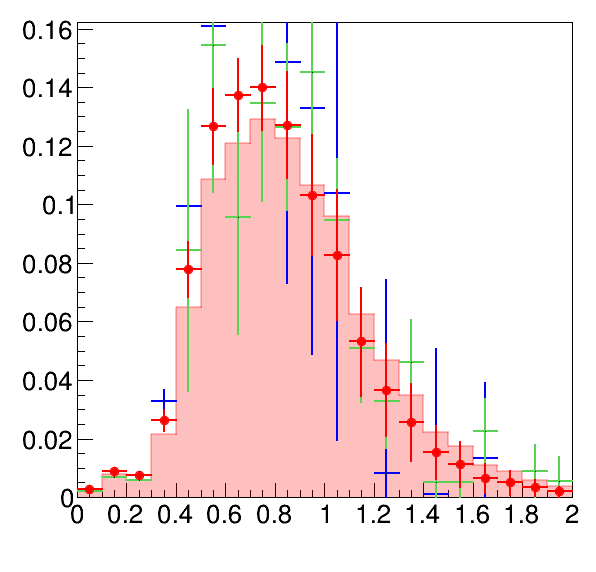

In [57]:
c = ROOT.TCanvas('c','c',600,600)

c.Clear()
data_unfolded['SVD'].DrawNormalized()


#data_binbybin.DrawNormalized("same")
hSR_Xj_truth.SetFillColorAlpha(2,0.25)
hSR_Xj_truth.SetLineColorAlpha(2,0.25)
hSR_Xj_truth.DrawNormalized('histsame')
data_unfolded['Bayes'].DrawNormalized('same')
data_unfolded['binbybin'].DrawNormalized('same')
data_unfolded['SVD'].DrawNormalized('same')

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file xjrefolding.png has been created


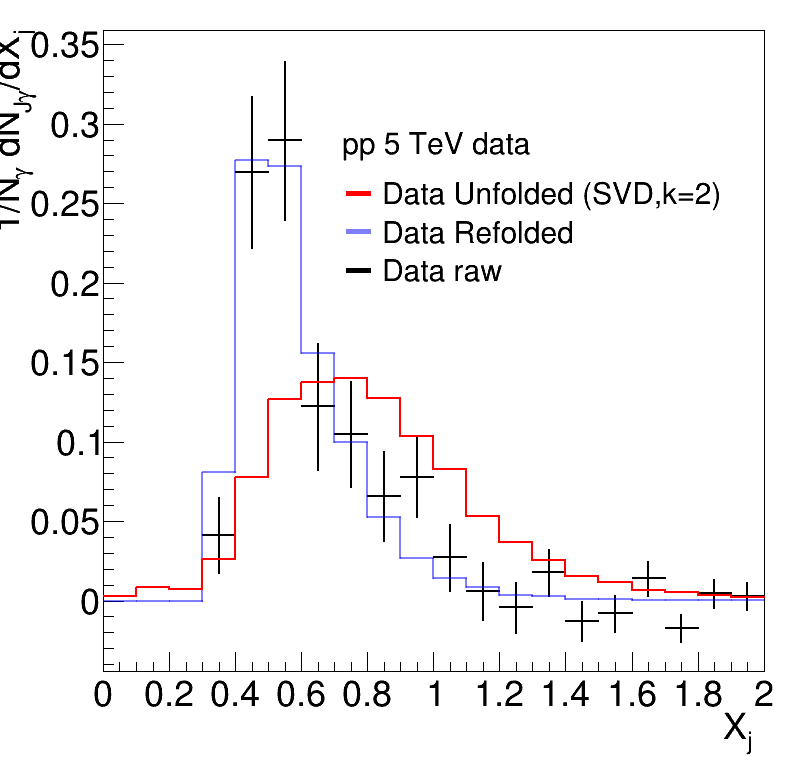

In [58]:
##refolding the distribution:
c = ROOT.TCanvas('c','c',800,800)

N = data_unfolded['SVD'].GetNbinsX()


data_refolded= data_unfolded['SVD'].Clone()
data_refolded.SetLineColorAlpha(4,0.5)

for ireco in range(0,N+1):
    temp = 0
    for itruth in range(0,N+1):
        #print responseMatrix.GetBinContent(itruth,ireco)
        #print data_unfolded['SVD'].GetBinContent(itruth)
        temp += responseMatrix.GetBinContent(itruth,ireco)*data_unfolded['SVD'].GetBinContent(itruth)
    data_refolded.SetBinContent(ireco, temp)
    
    
c.Clear()
data_inputforunfolding.DrawNormalized()
data_refolded.DrawNormalized('histsame')
data_unfolded['SVD'].DrawNormalized('histsame')

label = Legend("pp 5 TeV data")
label.Add(data_unfolded['SVD'], 'Data Unfolded (SVD,k=%i)'%SVD_k,'L')
label.Add(data_refolded, 'Data Refolded ','L')
label.Add(data_inputforunfolding, 'Data raw ','L')
label.Draw(.43,.8)


c.Draw()
c.SaveAs('xjrefolding.png')